In [119]:
%load_ext autoreload
#To update the imported files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
%autoreload
import sys

sys.path.insert(0, '../')
from constants import *
from utilities_RF import *

In [121]:
selected_features = ['date_forecast',
 'absolute_humidity_2m:gm3',
 'air_density_2m:kgm3',
 'clear_sky_energy_1h:J',
 'clear_sky_rad:W',
 'dew_or_rime:idx',
 'dew_point_2m:K',
 'diffuse_rad:W',
 'diffuse_rad_1h:J',
 'direct_rad_1h:J',
 'effective_cloud_cover:p',
 'elevation:m',
 'fresh_snow_12h:cm',
 'fresh_snow_1h:cm',
 'fresh_snow_24h:cm',
 'fresh_snow_3h:cm',
 'fresh_snow_6h:cm',
 'is_day:idx',
 'is_in_shadow:idx',
 'msl_pressure:hPa',
 'precip_5min:mm',
 'precip_type_5min:idx',
 'pressure_100m:hPa',
 'pressure_50m:hPa',
 'prob_rime:p',
 'rain_water:kgm2',
 'relative_humidity_1000hPa:p',
 'sfc_pressure:hPa',
 'snow_depth:cm',
 'snow_melt_10min:mm',
 'snow_water:kgm2',
 'sun_azimuth:d',
 'sun_elevation:d',
 'super_cooled_liquid_water:kgm2',
 't_1000hPa:K',
 'total_cloud_cover:p',
 'visibility:m',
 'wind_speed_10m:ms',
 'wind_speed_u_10m:ms',
 'wind_speed_v_10m:ms',
 'wind_speed_w_1000hPa:ms']
hyperparameters = {'max_depth': None, 'n_estimators': 200, 'n_jobs' : -1}

In [122]:
rf_a = Random_Forest(hyperparameters, X_observed_a, X_estimated_a, y_a, selected_features)
rf_a.fit()
rf_a.pred()

rf_b = Random_Forest(hyperparameters, X_observed_b, X_estimated_b, y_b, selected_features)
rf_b.fit()
rf_b.pred()

rf_c = Random_Forest(hyperparameters, X_observed_c, X_estimated_c, y_c, selected_features)
rf_c.fit()
rf_c.pred()

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623

In [123]:
#Evaluate mean asbolute error
mae_a = rf_a.mae()
print("A: Mean Absolute Error:", mae_a)

mae_b = rf_b.mae()
print("B: Mean Absolute Error:", mae_b)

mae_c = rf_c.mae()
print("C: Mean Absolute Error:", mae_c)

A: Mean Absolute Error: 179.96046363369535
B: Mean Absolute Error: 32.21412986413803
C: Mean Absolute Error: 19.694023760224947


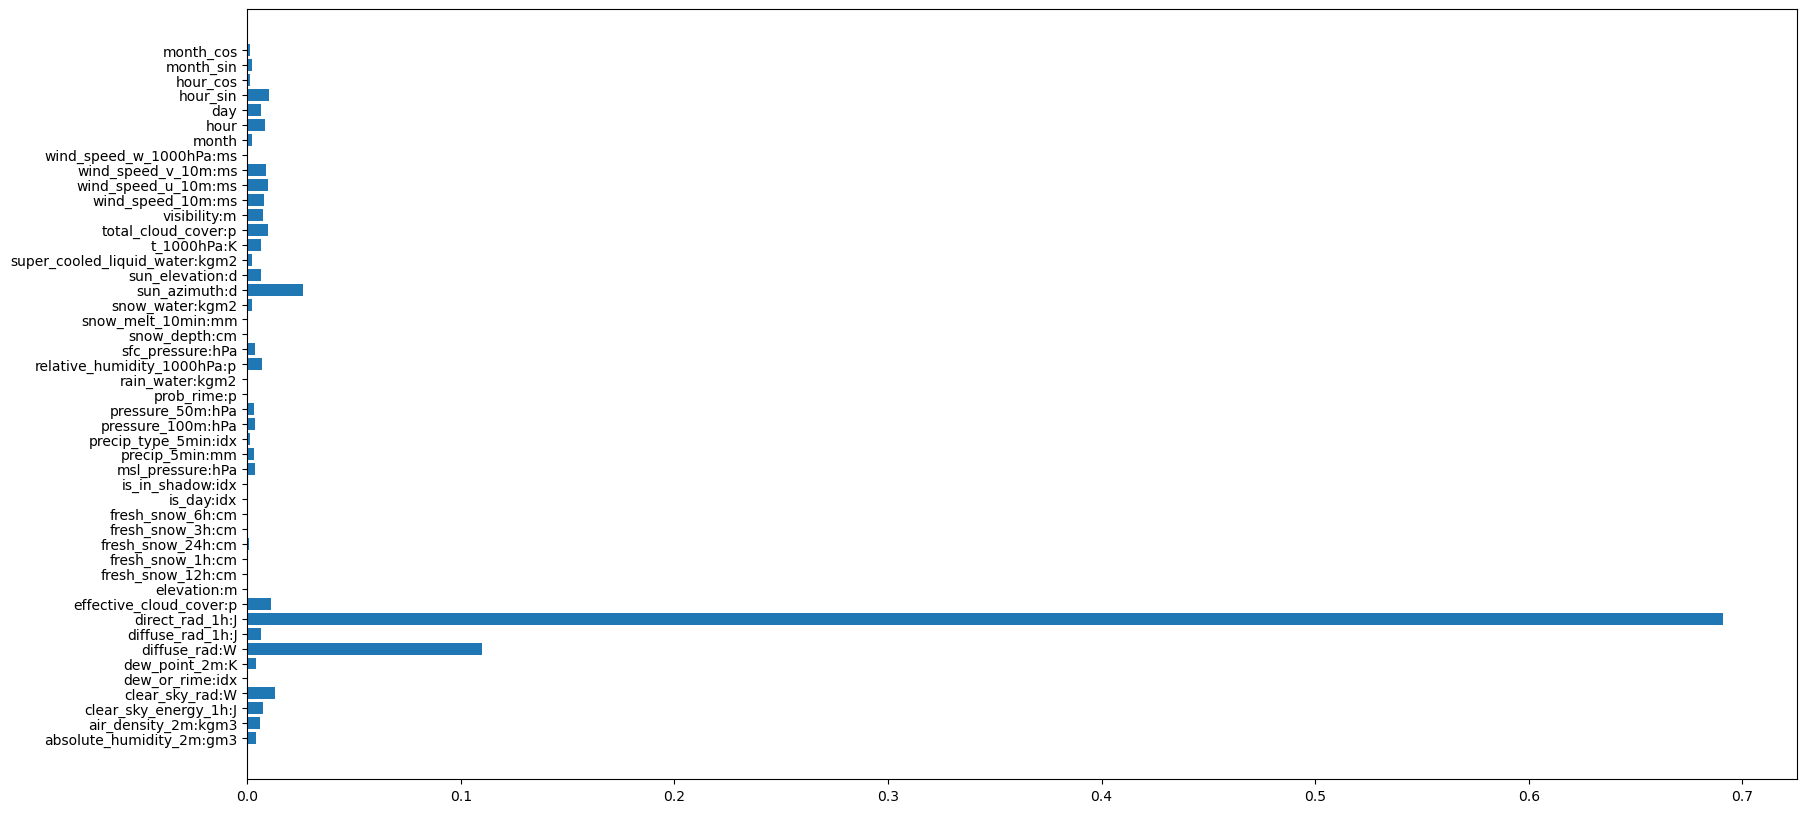

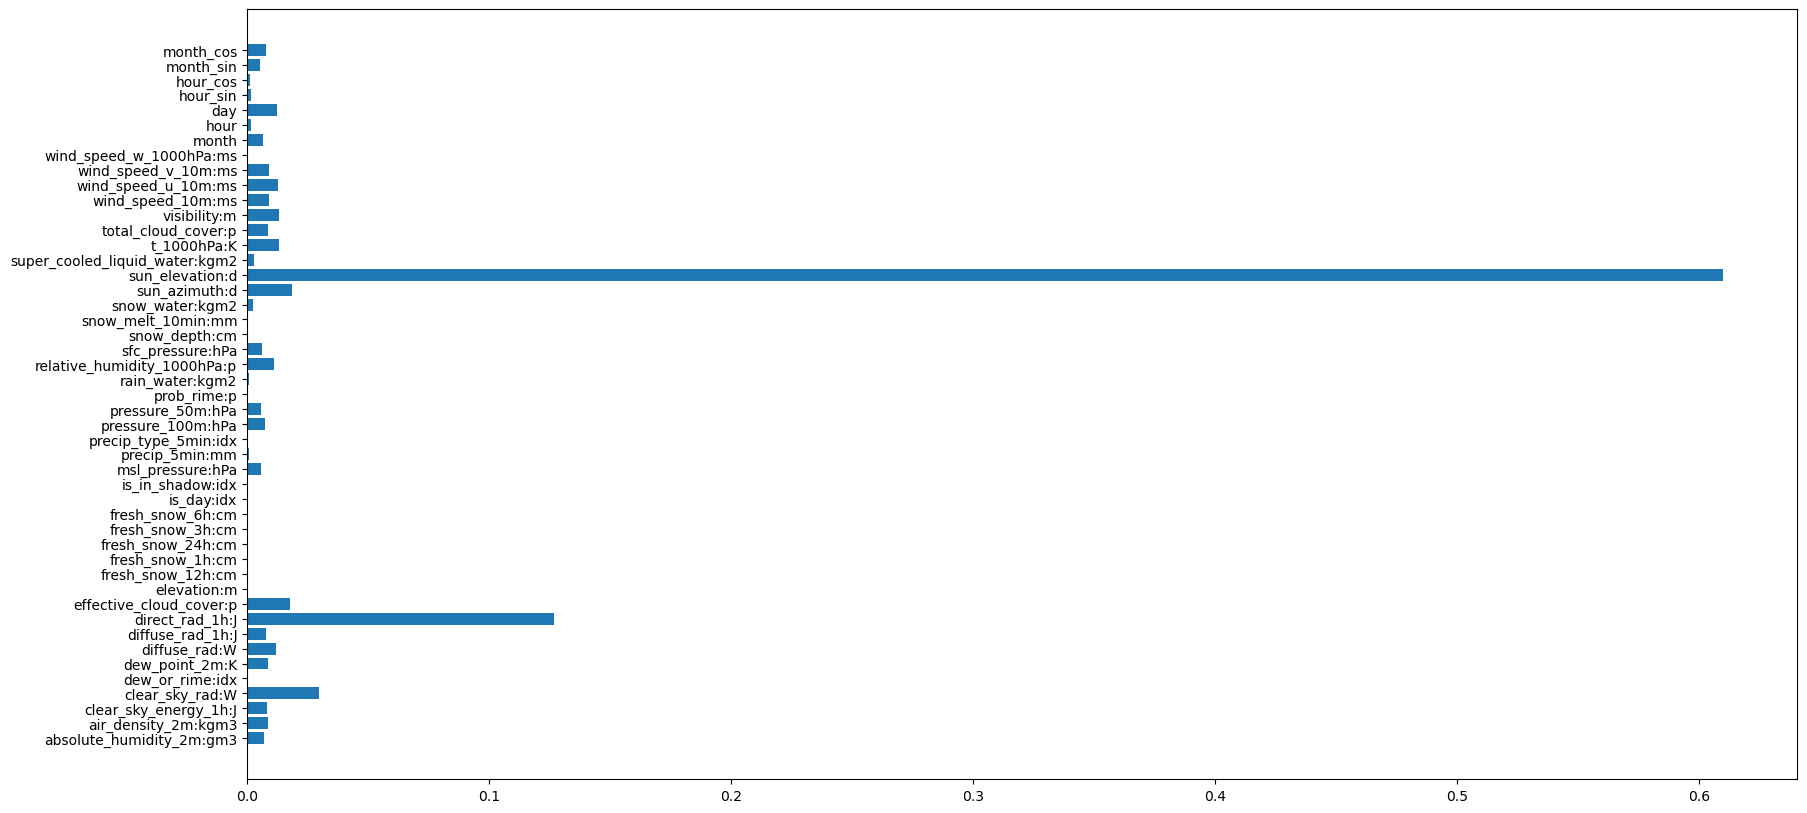

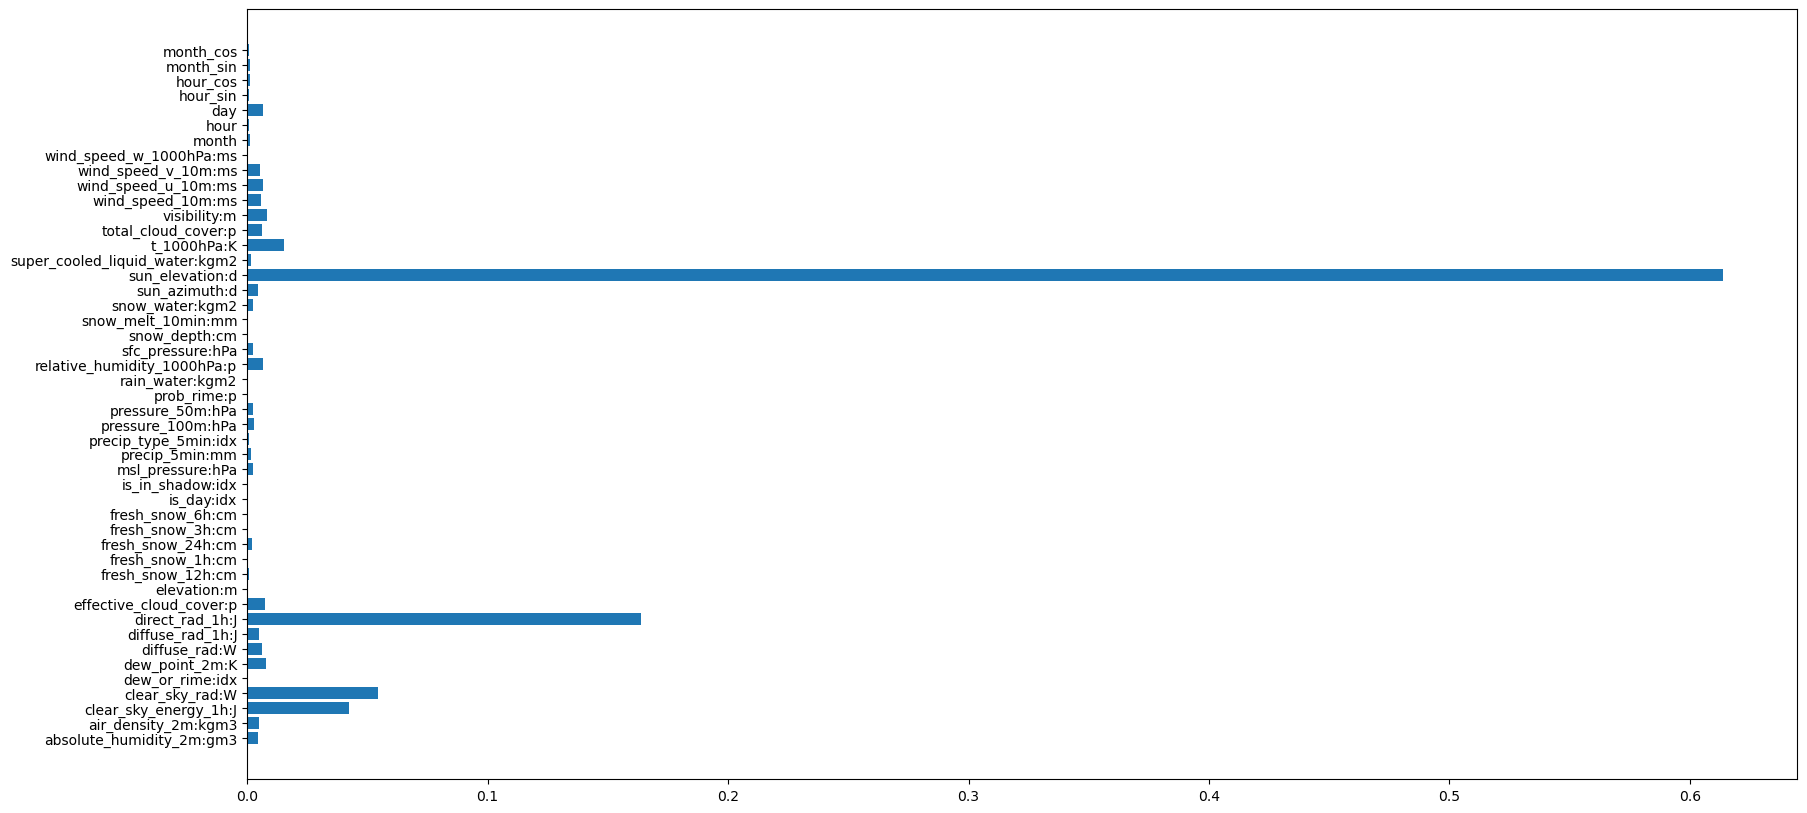

In [124]:
rf_a.feature_importence_plot()
rf_b.feature_importence_plot()
rf_c.feature_importence_plot()

In [125]:
rf_a.pred(X_test_a)
rf_b.pred(X_test_b)
rf_c.pred(X_test_c)

y_pred_rf_test = np.concatenate((rf_a.prediction, rf_b.prediction, rf_c.prediction), axis=0)
y_pred_rf_valid = np.concatenate((rf_a.pred_estimated, rf_b.pred_estimated, rf_c.pred_estimated), axis=0)

/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/simenfritzner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [126]:
submission("rf_main.csv", y_pred_rf_test, "../../")